<a href="https://colab.research.google.com/github/bboerschinger/colabs/blob/master/Transformer_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are interactive annotations for "Attention is all you need", https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf.

Focus on simplicity and readability, and using "plain" tensorflow.

In [ ]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except:
  strategy = tf.distribute.get_strategy()

INFO:tensorflow:Initializing the TPU system: grpc://10.30.147.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.147.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
D_MODEL = 512  # dimensionality of the vectors

We call our particular attention "Scaled Dot-Product Attention":

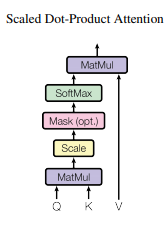

The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the
query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as: 

$$ Attention(Q, K, V ) = softmax(\frac{QK^{T}}{\sqrt{d_k}})V  $$

The two most commonly used attention functions are additive attention [2], and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [3]. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask):
  """Computes scaled-dot-product attention.

  Args:
    Q:  [batch_size, length_q, num_hidden]
    K:  [batch_size, length_v, num_hidden]
    V:  [batch_size, length_v, num_hidden]
    mask:  [batch_size, length_q, length_v]

  Note:  The mask is on the values, as we attend from queries to values by way
    of keys.    

  Returns:
    [batch_size, length_q, num_hidden]
  """

  d_k = tf.shape(input=K)[2]
  sqrt_d_k = tf.math.sqrt(tf.cast(d_k, tf.float32))

  # [batch_size, length_q, length_v]
  attention_logits = tf.matmul(Q, K, transpose_b=True) / sqrt_d_k

  if mask is not None:
    # [batch_size, length_q, length_v]
    negative_weights = (1.0 - tf.cast(mask, tf.float32)) * -10000.0
    # Effectively zero out the masked positions by giving them a big negative
    # logit.
    attention_logits = attention_logits + negative_weights
  
  # [batch_size, length_q, length_v]
  attention_weights = tf.nn.softmax(attention_logits)

  return tf.matmul(attention_weights, V)

*Some helpers for masking - this is not discussed in the paper as it's "common knowledge", but it's core.*

*The tl'dr is that*
- *for the source sequence, we use a vacuous "full attention" mask, i.e., every token gets to attend to every other token;*
- *same goes for the target to source attention; each target token is allowed to attend to every source token.  Note however that these sequences may be of different length;*
- *the target attention is a lower-triangular binary matrix;  this is to ensure that the first token may only attend to itself, the second token may attend to the first and itself, the third to the first, the second, and itself, and so on...*

In [ ]:
def self_attention_mask_for_inputs(seq, padding_token=0):
  """seq:  [batch_size, seq_length]"""
  return cross_attention_mask_for_inputs(seq, seq, padding_token)

def cross_attention_mask_for_inputs(query_seq, value_seq, padding_token=0):
  """query_seq:  [batch_size, query_seq_length]
     value_seq:  [batch_size, value_seq_length]

  Returns:
    A [batch_size, query_seq_length, value_seq_length] attention mask.
  """
  batch_size, query_length = tf.shape(query_seq)
  _, value_length = tf.shape(value_seq)

  full_attention = tf.ones(shape=(batch_size, query_length, value_length), dtype=tf.int32)

  query_mask = tf.cast(query_seq == padding_token, tf.int32)
  value_mask = tf.cast(value_seq != padding_token, tf.int32)
  return (full_attention - tf.expand_dims(query_mask, axis=2)) * tf.expand_dims(value_mask, axis=1)

def sequence_mask(q):
  """q:  [batch_size, seq_length]

  Returns:
    A [1, seq_length, seq_length] lower-triangular binary matrix.
  """
  seq_length = tf.shape(q)[1]
  return tf.expand_dims(
      tf.linalg.band_part(
          tf.ones(shape=(seq_length, seq_length), dtype=tf.int32), -1, 0), 
          axis=0)

Instead of performing a single attention function with $d_\text{model}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in this figure:

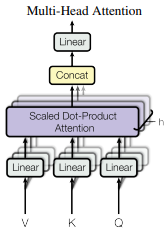

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

\begin{align}
  \text{MultiHead}(Q, K, V ) & = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^{O} \\
  \text{where head}_i& = \text{Attention}(QW^{Q}_i, KW^{K}_i, VW^{V}_i)
\end{align}

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}}\times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}}\times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}}\times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h = 8$ parallel attention layers, or heads. For each of these we use $d_k = d_v = d_{\text{model}}/h = 64$. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, num_heads=8):
    super().__init__()

    self.num_heads = num_heads

  def build(self, input_shape):
    # Keras only passes the first argument to build, which in our case is
    # `Q`.  Because we assume that all dimensionalities are identical, this is
    # not an issue.
    d_model = input_shape[-1]

    d_h = d_model // self.num_heads

    # The weight matrices, one set of of Q,K,V for each head.
    self.W = {}
    for x in ('Q', 'K', 'V'):
      for i in range(self.num_heads):
        # <float> [d_model, d_h]
        self.W[f'{x}_{i}'] = self.add_weight(f'{x}_{i}',
                                             shape=(d_model, d_h))     
        
    # The single O-matrix.        
    self.W['O'] = self.add_weight('O',
                                  shape=(d_model, d_model))
    
  def call(self, Q, K, V, mask=None):
    """
    Args:
      Q:  [batch_size, length_q, d_model]
      K:  [batch_size, length_v, d_model]
      V:  [batch_size, length_v, d_model]
      mask:  [batch_size, length_v]
    """
    # Note:  A pattern more commonly observed is to use a single linear
    #        projection (d_model, d_model) for Q, one for K, one for V, and
    #        then splitting the resulting d_model-dimensional vectors into
    #        num_heads d_h-dimensional vectors.
    #        This makes for a more efficient implementation but obfuscates the
    #        relation to the original paper description.

    heads = []
    for i in range(self.num_heads):
      heads.append(
          # Compute the i-th head attention.
          scaled_dot_product_attention(
              # Linearly project queries / keys / values for the i-th head.
              Q=tf.matmul(Q, self.W[f'Q_{i}']),
              K=tf.matmul(K, self.W[f'K_{i}']),
              V=tf.matmul(V, self.W[f'V_{i}']),
              mask=mask))
      
    concat = tf.concat(heads, axis=-1)
    return tf.matmul(concat, self.W['O'])

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed [9].

In this work, we use sine and cosine functions of different frequencies:

\begin{align}
  PE_{(pos,2i)} &= \sin(pos/10000^{2i/d_{\text{model}}}) \\
  PE_{(pos,2i+1)} &= \cos(pos/10000^{2i/d_{\text{model}}})
\end{align}

*We only compute this once, so we keep this simple*.

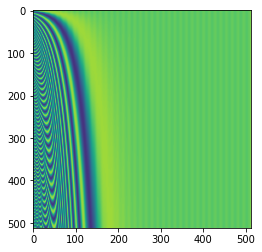

In [ ]:
def position_encoding(pos, hidden_dimensions: int):
  """Compute the embedding vector for position `pos`."""
  def dimension(i):
    fix_term = pos / math.pow(10000.0, 2.0*i / hidden_dimensions)
    if i % 2.0 == 0.0:
      return math.sin(fix_term)
    else:
      return math.cos(fix_term)

  vector_for_pos = []
  for i in range(hidden_dimensions):
    vector_for_pos.append(dimension(i))

  return vector_for_pos

def make_position_embeddings(seq_length: int, d_model: int):
  """Compute the matrix of position vectors we can just add to the learned
     word-embeddings."""
  vectors = []
  for pos in range(seq_length):
    vectors.append(position_encoding(pos=pos,
                                     hidden_dimensions=d_model))

  return tf.convert_to_tensor(vectors)

# 512 tokens should be enough for anyone...
POSITION_EMBEDDINGS = make_position_embeddings(seq_length=512, d_model=D_MODEL)
plt.imshow(POSITION_EMBEDDINGS)

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [30]. In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [ ]:
class InputEmbedding(tf.keras.layers.Layer):

  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size

    self.embeddings = tf.keras.layers.Embedding(input_dim=self.vocab_size, 
                                                output_dim=self.d_model)
    
    self.dropout = tf.keras.layers.Dropout(rate=0.1)
    
   
  def call(self, inputs):
    """
    Args:
      inputs:  [batch_size, seq_length]
    """
    seq_length = tf.shape(inputs)[1]

    # [batch_size, seq_length, d_model]
    token_embeddings = self.embeddings(inputs)* tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    # [1, seq_length, d_model]
    position_embeddings = tf.expand_dims(POSITION_EMBEDDINGS[:seq_length, :],
                                         axis=0)

    # "we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks"
    return self.dropout(token_embeddings + position_embeddings)

  # Expose the weights so we can potentially re-use them.
  def get_weights(self):
    return self.embeddings.trainable_weights[0]

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

\begin{equation}
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2 
\end{equation}

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_\text{model} = 512$, and the inner-layer has dimensionality $d_{ff} = 2048$.

In [ ]:
class FFN(tf.keras.layers.Layer):
  def __init__(self, d_ff=2048):
    super().__init__()
    self.d_ff = d_ff


  def build(self, input_shape):
    d_model = input_shape[-1]

    self.W1 = self.add_weight(shape=(d_model, self.d_ff))
    self.b1 = self.add_weight(shape=(self.d_ff,))
    self.W2 = self.add_weight(shape=(self.d_ff, d_model))
    self.b2 = self.add_weight(shape=(d_model,))


  def call(self, inputs):
    """
    Args:
      inputs:  [batch_size, seq_length, d_model]
    """
    return tf.matmul(
        tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1), self.W2) + self.b2

**Encoder:** The encoder is composed of a stack of $N = 6$ identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection [11] around each of the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is $\text{LayerNorm}(x + \text{Sublayer}(x))$, where $\text{Sublayer}(x)$ is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_\text{model} = 512$.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads=8, d_ff=2048):
    super().__init__()

    self.mh_attention = MultiHeadAttention(num_heads=num_heads)
    self.ffn = FFN(d_ff=d_ff)

    self.attention_layer_norm = tf.keras.layers.LayerNormalization()
    self.ffn_layer_norm = tf.keras.layers.LayerNormalization()

    self.dropout = tf.keras.layers.Dropout(rate=0.1)    

  def call(self, inputs, mask):
    """
    Args:
      inputs:  [batch_size, seq_length, d_model]
      mask:    [batch_size, seq_length] or None
    """

    # We apply dropout [33] to the output of each sub-layer, before it is added to the
    # sub-layer input and normalized.
    attention_layer_output = self.attention_layer_norm(
        inputs + self.dropout(self.mh_attention(Q=inputs, K=inputs, V=inputs, mask=mask)))
    ffn_layer_output = self.ffn_layer_norm(
        attention_layer_output + self.dropout(self.ffn(attention_layer_output)))
    return ffn_layer_output

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads=8, d_ff=2048):
    super().__init__()

    self.mh_self_attention = MultiHeadAttention(num_heads=num_heads)
    self.ffn = FFN(d_ff=d_ff)
    self.mh_cross_attention = MultiHeadAttention(num_heads=num_heads)

    self.self_attention_layer_norm = tf.keras.layers.LayerNormalization()
    self.cross_attention_layer_norm = tf.keras.layers.LayerNormalization()
    self.ffn_layer_norm = tf.keras.layers.LayerNormalization()

    self.dropout = tf.keras.layers.Dropout(rate=0.1)

  def call(self, inputs, encoder_outputs, cross_attention_mask, self_attention_mask):
    """
    Args:
      inputs:  [batch_size, seq_length_trg, d_model]
      encoder_outputs:  [batch_size, seq_length_src, d_model]
      srcs_mask:  [batch_size, seq_length_src]
      trg_mask:  [batch_size, seq_length_trg]
    """
    # We apply dropout [33] to the output of each sub-layer, before it is added to the
    # sub-layer input and normalized.
    self_attention_output = self.self_attention_layer_norm(
        inputs + self.dropout(self.mh_self_attention(Q=inputs,
                                                     K=inputs,
                                                     V=inputs,
                                                     mask=self_attention_mask)))
    
    cross_attention_output = self.cross_attention_layer_norm(
        self_attention_output + self.dropout(self.mh_cross_attention(
            Q=self_attention_output,
            K=encoder_outputs,
            V=encoder_outputs,
            mask=cross_attention_mask)))
    
    ffn_output = self.ffn_layer_norm(cross_attention_output + 
                                     self.dropout(self.ffn(cross_attention_output)))
    
    return ffn_output

In [ ]:
def make_encoder(vocab_size, 
                 d_model=512, 
                 n_layers=6, 
                 num_heads=8):
  # [batch_size, seq_length]
  input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')

  # [batch_size, seq_length, d_model]
  input_embedder = InputEmbedding(d_model=d_model, vocab_size=vocab_size)

  # [batch_size, seq_length, num_hidden]
  embedded = input_embedder(input_ids)

  # Run the encoder tower.
  for _ in tf.range(n_layers):
    embedded = EncoderLayer(num_heads=num_heads)(inputs=embedded, mask=self_attention_mask_for_inputs(seq=input_ids))

  return tf.keras.Model(inputs=(input_ids,), outputs=embedded)

In [ ]:
def make_decoder(vocab_size, input_embedder, d_model=512, n_layers=6, num_heads=8):
  # [batch_size, q_seq_length]
  input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  # [batch_size, v_seq_length]
  source_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='source_ids')
  # [batch_size, v_seq_length, d_model]
  encoder_outputs = tf.keras.Input(shape=(None, d_model), dtype=tf.float32, name='encoder_outputs')

  # [batch_size, q_seq_length, q_seq_length]
  input_masks = sequence_mask(input_ids)

  # [batch_size, q_seq_length, v_seq_length]
  cross_attention_masks = cross_attention_mask_for_inputs(query_seq=input_ids, 
                                                          value_seq=source_ids)

  # [batch_size, input_seq_length, d_model]
  embedded = input_embedder(input_ids)

  # Run the decoder tower.
  for _ in tf.range(n_layers):
    embedded = DecoderLayer(num_heads=num_heads)(inputs=embedded, 
                              encoder_outputs=encoder_outputs, 
                              cross_attention_mask=cross_attention_masks, 
                              self_attention_mask=input_masks)
    
  return tf.keras.Model(inputs=(input_ids, source_ids, encoder_outputs),
                        outputs=embedded)

In [ ]:
def make_generator(d_model, weights):
  # [batch_size, seq_length, d_model]
  input_embeddings = tf.keras.Input(shape=(None, d_model), dtype=tf.float32, name='input_embeddings')

  # [batch_size, seq_length, vocab_size]
  output_logits = tf.matmul(input_embeddings, weights, transpose_b=True)

  return tf.keras.Model(inputs=(input_embeddings,), outputs=output_logits)

We used the Adam optimizer [20] with $\beta_1 = 0.9$, $\beta_2 = 0.98$ and $\epsilon = 10^{−9}$. We varied the learning rate over the course of training, according to the formula:
\begin{equation}
lrate = d_{\text{model}}^{−0.5} \cdot \min(step_{num}^{−0.5}
, step_{num} · warmup\_steps^{−1.5})
\end{equation}

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number. We used
warmup_steps = 4000.

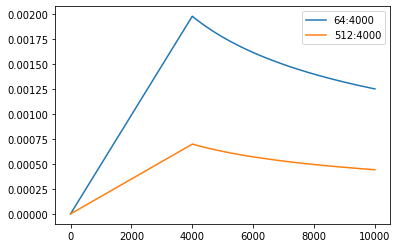

In [ ]:
@tf.function
def lrate(step, 
          warmup_steps, 
          d_model):
  return tf.math.pow(d_model, -0.5) * tf.minimum(tf.math.pow(step+1.0, -0.5), (step+1.0) * tf.math.pow(warmup_steps, -1.5))

class LRate(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, warmup_steps, d_model=512):
    super().__init__()
    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    self.d_model = tf.cast(d_model, tf.float32)

  def __call__(self, step):
    return lrate(step=tf.cast(step, tf.float32), 
                 warmup_steps=self.warmup_steps, 
                 d_model=self.d_model)

legend = []
steps = 10000
for warmup_steps in (4000,):
  for model_size in (64, 512):
    lr_fn = LRate(warmup_steps=warmup_steps, d_model=model_size)
    plt.plot(range(steps), [lr_fn(x) for x in range(steps)])
    legend.append(f'{model_size}:{warmup_steps}')
plt.legend(legend)

*Now perform a toy task, copying the input.  Depending on the runtim, this should work with CPU (extremely slow), GPU (fairly slow), and TPU (reasonably fast).*

*A toy task - copy the input.*

In [ ]:
def make_copy_example_batch(batch_size, seq_length, vocab_size):
  """Copy task.

  Returns (x, y, y_target), where
    x is a random sequence of at most length `seq_length`;
    y is x, but prepended with a `1` as the "start token";
    
    The target will be x itself.
  """
  x = tf.random.uniform(shape=(batch_size, seq_length), minval=1, maxval=vocab_size, dtype=tf.int32)
  y = tf.concat((tf.ones(shape=(batch_size, 1), dtype=tf.int32), x), axis=1)

  return (x, y)

def make_dataset(batch_size, seq_length, vocab_size, num_batches):
  data = []
  labels = []
  for _ in range(num_batches):
    d, l = make_copy_example_batch(batch_size=batch_size,
                                    seq_length=seq_length, vocab_size=vocab_size)
    data.append(d)
    labels.append(l)
  return tf.data.Dataset.from_tensor_slices((data, labels))

In [ ]:
def train_model(global_batch_size, seq_length, vocab_size, num_batches, num_epochs, n_layers=2, num_heads=8):
  with strategy.scope():
    encoder = make_encoder(vocab_size=vocab_size, d_model=D_MODEL, n_layers=n_layers, num_heads=num_heads)

    decoder_embedder = InputEmbedding(d_model=D_MODEL, vocab_size=vocab_size)
    decoder = make_decoder(vocab_size=vocab_size,
                          input_embedder=decoder_embedder,
                          d_model=D_MODEL, n_layers=n_layers, 
                          num_heads=num_heads)

    generator = make_generator(d_model=D_MODEL, weights=decoder_embedder.get_weights())
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRate(warmup_steps=4000, d_model=D_MODEL), 
                                        beta_1=0.9, 
                                        beta_2=0.98, 
                                        epsilon=1e-9)

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables + generator.trainable_variables
  loss_val = 0

  def step_fn(x, y):
    with tf.GradientTape() as tape:
      encoder_output = encoder({
          'input_ids': x,
      }, training=True)
    
      decoder_outputs = decoder(
          {'input_ids': y,
           'source_ids': x,
           'encoder_outputs': encoder_output,
          }, training=True)
      
      # Skip prediction from the last token.
      generator_outputs = generator({'input_embeddings': decoder_outputs}, 
                                    training=True)[:, :-1, :]

      loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
          y_true=tf.one_hot(indices=x, depth=vocab_size),
          y_pred=generator_outputs,
          from_logits=True,
          label_smoothing=0.0))
    
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))  
    return loss

  @tf.function
  def epoch_fn(dataset):
    loss_val = 0.
    num_batches = 0.
    for (x, y) in dataset:
      loss_val += strategy.reduce(
          tf.distribute.ReduceOp.MEAN, 
          strategy.run(
              step_fn, (x, y,)), 
          axis=None)
      num_batches += 1
    return loss_val / num_batches

  dataset = strategy.experimental_distribute_dataset(
      make_dataset(batch_size=global_batch_size, 
                   seq_length=seq_length, 
                   vocab_size=vocab_size, 
                   num_batches=num_batches))
  tokens_per_epoch = num_batches * seq_length * global_batch_size

  for epoch in range(num_epochs):
    start_time = tf.timestamp()
    loss_val = epoch_fn(dataset)
    epoch_time = tf.timestamp() - start_time
    
    tokens_per_second = tokens_per_epoch / epoch_time
    print(f'Epoch {epoch}: {loss_val}, tokens/sec: {tokens_per_second}')

  return {
      'encoder': encoder,
      'decoder': decoder,
      'generator': generator,
  }

In [ ]:
def greedy_decode(model, input_seq):
  batch_size, seq_length = tf.shape(input_seq)
  encoder_output = model['encoder']({
      'input_ids': input_seq,
  })

  target_seq = tf.ones(shape=(batch_size, 1), dtype=tf.int32)
  
  for pos in range(seq_length): 
    _, trg_len = tf.shape(target_seq)  
    decoder_outputs = model['decoder'](
        {'input_ids': target_seq,
          'source_ids': input_seq,
          'encoder_outputs': encoder_output,
        })
    
    # [batch_size, trg_len, vocab_size]
    generator_outputs = model['generator']({'input_embeddings': decoder_outputs})
    predictions = tf.argmax(generator_outputs[:, -1, :], axis=-1, output_type=tf.int32)
    target_seq = tf.concat((target_seq, tf.expand_dims(predictions, axis=1)), axis=-1)

  return target_seq[:, 1:]

def evaluate(model, seq_length, vocab_size):
  test_set_size = 128
  test_seq_lengths = (10, 50, 100, 105, 110, 120, 150)
  for l in test_seq_lengths:
    x, _ = make_copy_example_batch(batch_size=test_set_size, seq_length=l, vocab_size=vocab_size)
    x_hat = greedy_decode(model, x)
    
    print(f'l={l}, accuracy={tf.reduce_sum(tf.cast(x==x_hat, dtype=tf.float32)).numpy() / (l*test_set_size)}')
    if l > seq_length:
      x_over = x[:, seq_length:]
      x_hat_over = x_hat[:, seq_length:]
      print(f'  l={l}, excess accuracy={tf.reduce_sum(tf.cast(x_over==x_hat_over, dtype=tf.float32)).numpy() / ((l-seq_length)*test_set_size)}')

Train models on sequences of differing length.  Not surprising anyone, despite being able to perfectly fit, say, sequences of 100 when explicitly trained on them, when trained on sequences of length 50, performance breaks down when going beyond the length.

In [ ]:
vocab_size = 11
for train_length in (10, 50, 100):
  print(f'Training a model on sequences of length {train_length}')
  model = train_model(global_batch_size=64, seq_length=train_length, vocab_size=vocab_size, num_batches=100, num_epochs=10)
  evaluate(model=model, seq_length=train_length, vocab_size=vocab_size)
  print('')

Training a model on sequences of length 10
Epoch 0: 2.2891876697540283, tokens/sec: 982.1071887895989
Epoch 1: 1.8967583179473877, tokens/sec: 46015.82124906168
Epoch 2: 1.558152675628662, tokens/sec: 43523.91001922971
Epoch 3: 1.01461923122406, tokens/sec: 42783.8632423271
Epoch 4: 0.4761119782924652, tokens/sec: 42471.01443428217
Epoch 5: 0.1986444592475891, tokens/sec: 42625.913799364855
Epoch 6: 0.11062534153461456, tokens/sec: 42282.655611202164
Epoch 7: 0.08101654052734375, tokens/sec: 42066.2744656181
Epoch 8: 0.06458187848329544, tokens/sec: 41331.52077596917
Epoch 9: 0.05740635097026825, tokens/sec: 43855.29533391625
l=10, accuracy=0.99921875
l=50, accuracy=0.305
  l=50, excess accuracy=0.14453125
l=100, accuracy=0.204765625
  l=100, excess accuracy=0.12352430555555556
l=105, accuracy=0.1959077380952381
  l=105, excess accuracy=0.11842105263157894
l=110, accuracy=0.19183238636363636
  l=110, excess accuracy=0.117421875
l=120, accuracy=0.18841145833333334
  l=120, excess accura